In [259]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sparse_shift.plotting import plot_dag
import pickle

## DAGs in triangle MEC

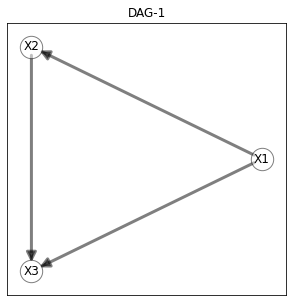

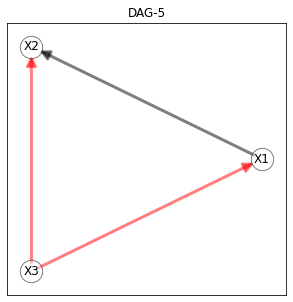

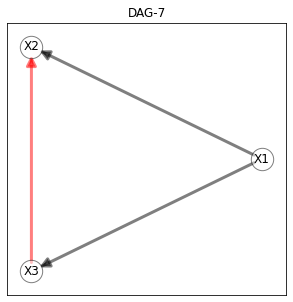

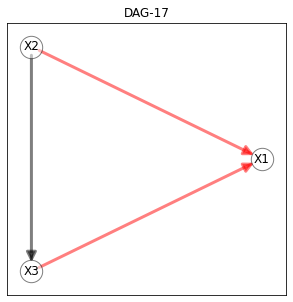

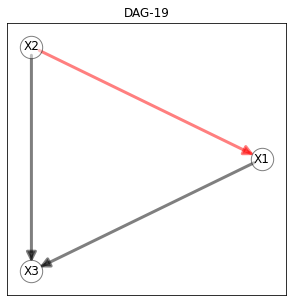

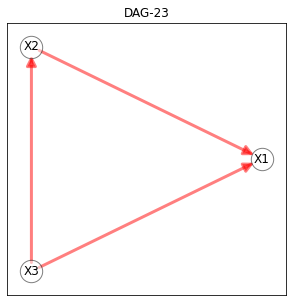

In [260]:
with open("./dag_dict_all_triangles.pkl", "rb") as f:
    dag_dict = pickle.load(f)

# Restrict to MEC
dag_dict = {
    key: dag for key, dag in dag_dict.items() if np.sum(dag) == 3
}

true_dag = 'DAG-1'
true_parents = dag_dict[true_dag]

for key, dag in dag_dict.items():
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        title=key)

In [268]:
df = pd.read_csv('./cdnod_triangle_pvalues.csv', header=[0, 1], delimiter=', ', engine='python')
df.head(5)

Params                                     DAG-1                DAG-5  \
  params_index intervention_targets n_samples rep     X1     X2     X3     X1   
0            0             [None,0]        50   0  0.271  0.485  0.535  0.842   
1            0             [None,0]        50   1  0.000  0.644  0.743  0.218   
2            0             [None,0]        50   2  0.026  0.584  0.921  0.604   
3            0             [None,0]        50   3  0.005  0.792  0.139  0.673   
4            0             [None,0]        50   4  0.000  0.158  0.663  0.535   

                 ...  DAG-7 DAG-17               DAG-19               DAG-23  \
      X2     X3  ...     X3     X1     X2     X3     X1     X2     X3     X1   
0  0.109  1.000  ...  0.168  0.762  0.155  0.713  0.089  0.155  0.564  0.505   
1  0.614  0.020  ...  0.257  0.020  0.057  0.584  0.188  0.057  0.851  0.020   
2  0.713  0.088  ...  0.376  0.238  0.086  0.881  0.040  0.086  0.921  0.277   
3  0.584  0.009  ...  0.861  0.713  0.003  0.109  0.416  0.003  0.119  0.673   
4  0.248  0.000  ...  0.188  0.069  0.000  0.792  0.624  0.000  0.653  0.069   

                 
      X2     X3  
0  0.624  1.000  
1  0.475  0.020  
2  0.653  0.088  
3  0.901  0.009  
4  0.446  0.000  

[5 rows x 22 columns]

In [289]:
dag2mech = {
    dag: {
        f'X{i+1}': 'PA=(' + ','.join(
            list(np.where(pars == 1)[0].astype(str))
        ) + ')'
        for i, pars in enumerate(parents)
    }
    for dag, parents in dag_dict.items()
}

In [304]:
alpha = 0.05
dfs = []
for dag_key in dag2mech.keys():
    for variable, mech in dag2mech[dag_key].items():
        power_df = df['Params']
        power_df.loc[:, 'variable'] = variable
        power_df.loc[:, 'mechanism'] = mech
        power_df.loc[:, 'test_power'] = (df[dag_key][variable] <= alpha).astype(int)
        dfs.append(power_df)
        
power_df = pd.concat(dfs, axis=0)

/Users/rflperry/opt/miniconda3/envs/kcd/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


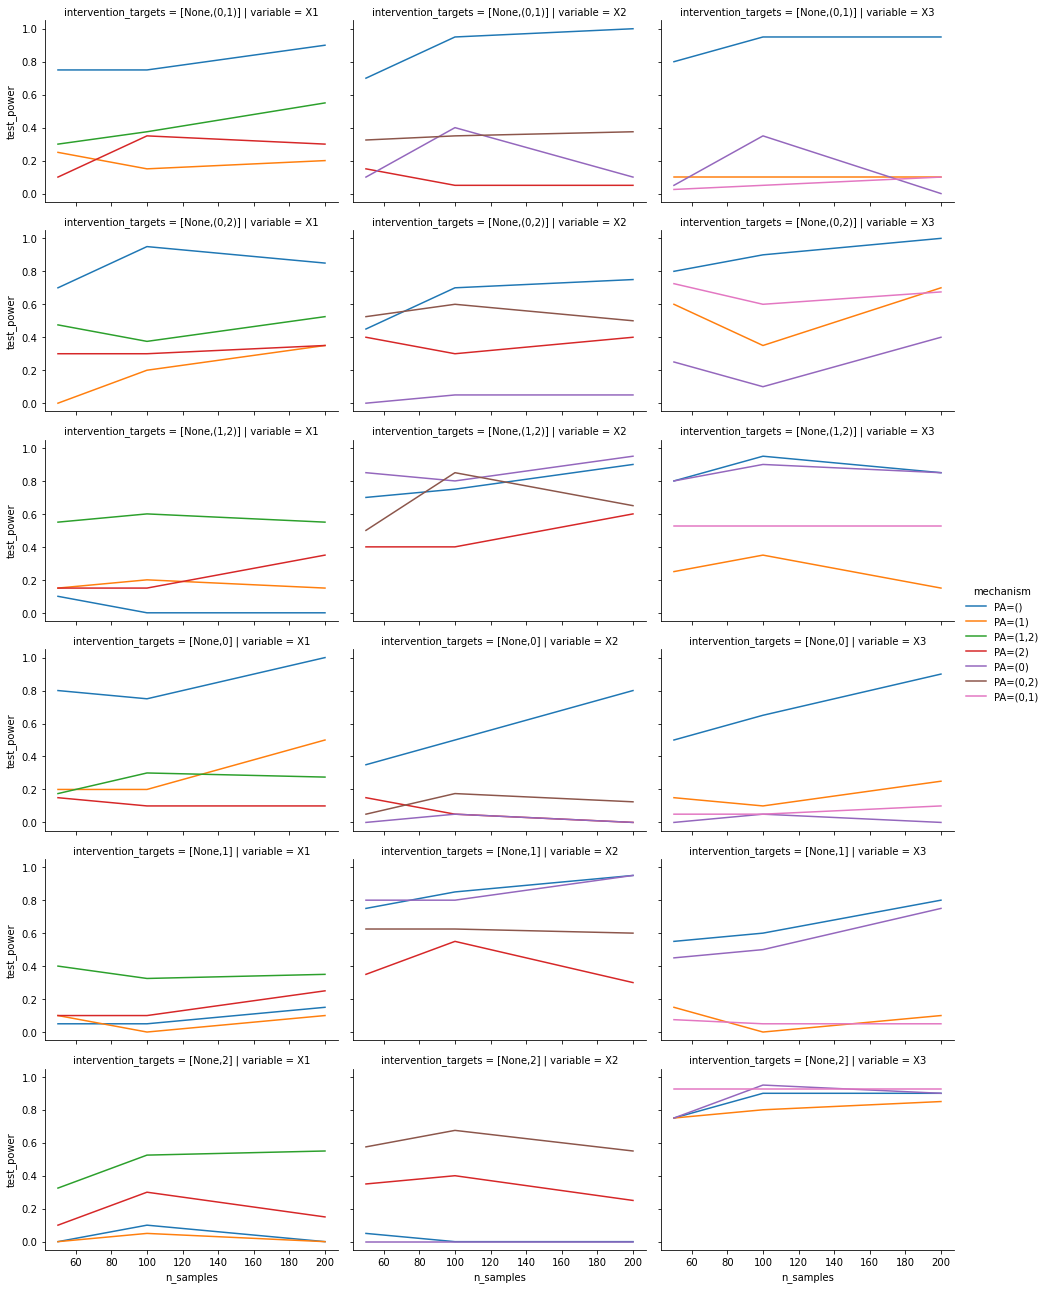

In [309]:
g = sns.relplot(
    data=power_df.groupby(
        ['intervention_targets', 'n_samples', 'variable', 'mechanism']
    ).mean().reset_index(),
    col='variable',
    row='intervention_targets',
    x = 'n_samples',
    y = 'test_power',
    hue='mechanism',
    kind='line',
    height=3, aspect=1.5,
    # legend=False,
)
plt.show()

In [225]:
alpha = 0.05 / 3
df_mat = []

for key, idx in df['Params'].groupby(['n_samples', 'intervention_targets']).indices.items():
    for dag_key in dag_dict.keys():
        n_changes = (df[dag_key].iloc[idx] <= alpha).sum(1)
        for n_env in [i for i in range(1, n_changes.shape[0]+1) if (n_changes.shape[0] % i) == 0]:
            for i, subgroup in enumerate(np.split(n_changes, int(n_changes.shape[0] / n_env))):
                df_mat.append(
                    list(key) + [i, 2*n_env, dag_key, np.sum(subgroup), np.mean(subgroup)]
                )
                
metric_df = pd.DataFrame(df_mat, columns=[
    'n_samples', 'intervention_targets', 'rep', 'n_environments', 'dag', 
    'n_changes', 'mean_changes',
])

In [226]:
changes_df = pd.pivot_table(metric_df, index=[
    'n_samples', 'intervention_targets',
    'n_environments', 'rep'],
    values='mean_changes',
    columns='dag').reset_index()

dags = metric_df['dag'].unique()

changes_df['mean_min_changes'] = changes_df[dags].min(1)
changes_df['min_set_size'] = np.sum([changes_df[dag] == changes_df['mean_min_changes'] for dag in dags], 0)
changes_df['true_in_min_set'] = changes_df[true_dag] == changes_df['mean_min_changes']

[None,(0,1)]


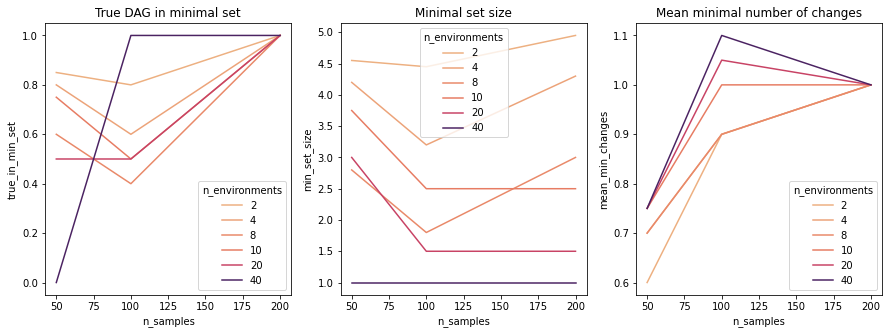

[None,(0,2)]


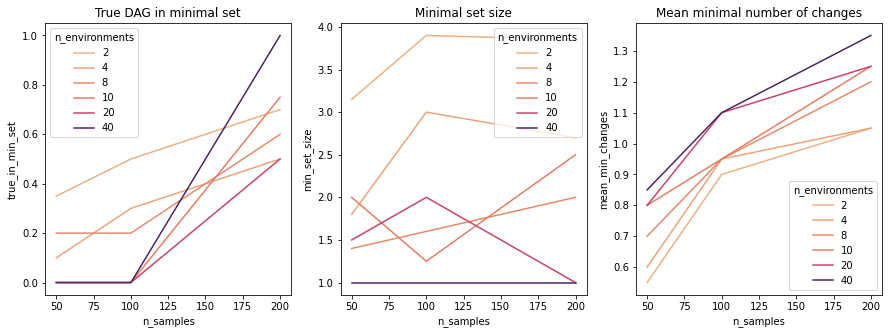

[None,(1,2)]


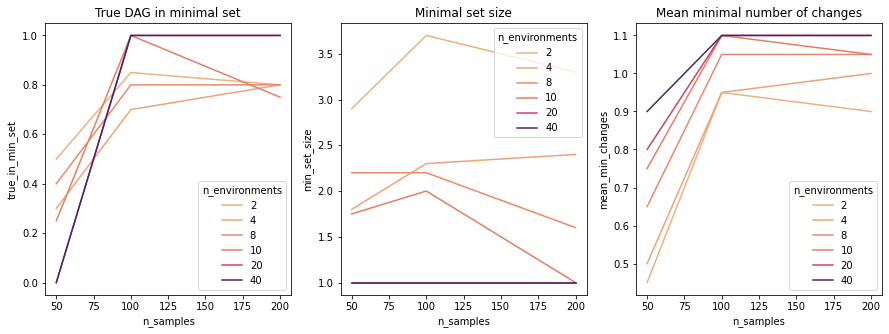

[None,0]


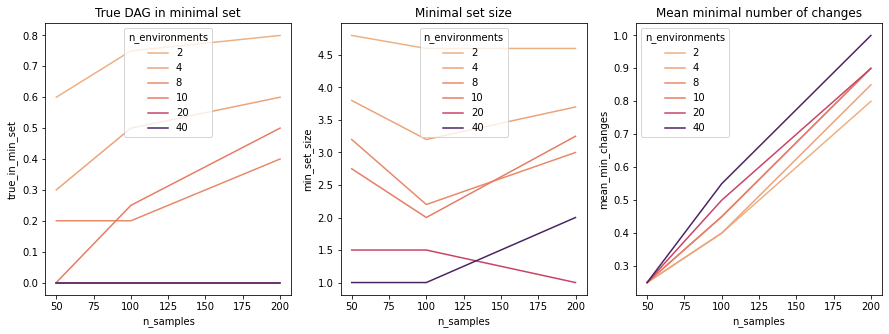

[None,1]


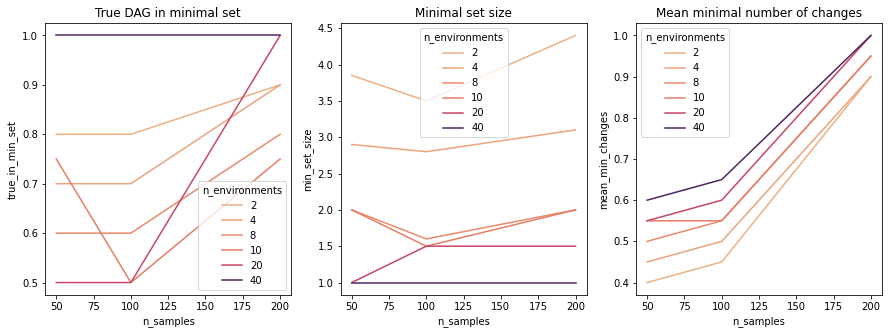

[None,2]


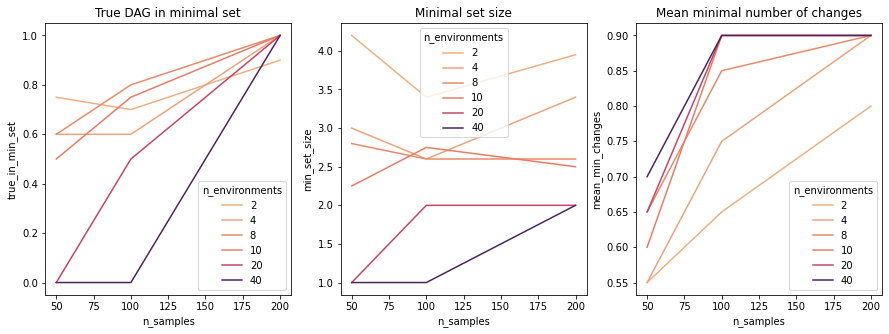

In [325]:
for targets in changes_df['intervention_targets'].unique():
    print(targets)
    sub_df = changes_df[changes_df['intervention_targets'] == targets]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.lineplot(
        data=sub_df.groupby(['n_samples', 'n_environments', 'rep']).mean().reset_index(),
        x='n_samples', y='true_in_min_set', hue='n_environments', ci=None,
        ax=axes[0] , palette='flare')
    axes[0].set_title('True DAG in minimal set')
    
    sns.lineplot(
        data=sub_df.groupby(['n_samples', 'n_environments', 'rep']).mean().reset_index(),
        x='n_samples', y='min_set_size', hue='n_environments', ci=None,
        ax=axes[1], palette='flare'
    )
    axes[1].set_title('Minimal set size')
    
    sns.lineplot(
        data=sub_df.groupby(['n_samples', 'n_environments', 'rep']).mean().reset_index(),
        x='n_samples', y='mean_min_changes', hue='n_environments', ci=None,
        ax=axes[2], palette='flare'
    )
    axes[2].set_title('Mean minimal number of changes')
    
    plt.show()

Targets:  [None,0]


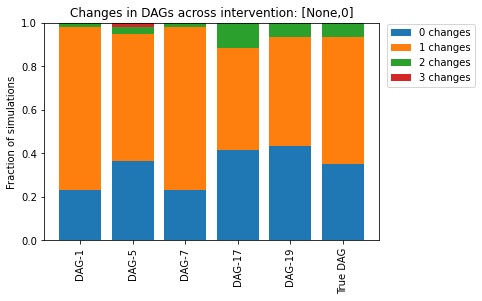

Targets:  [None,1]


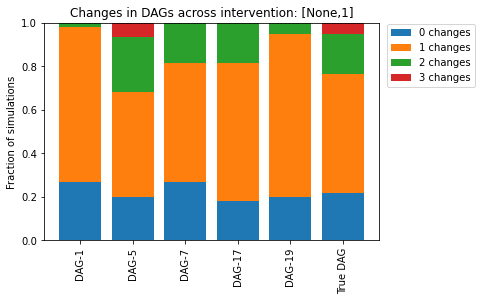

Targets:  [None,2]


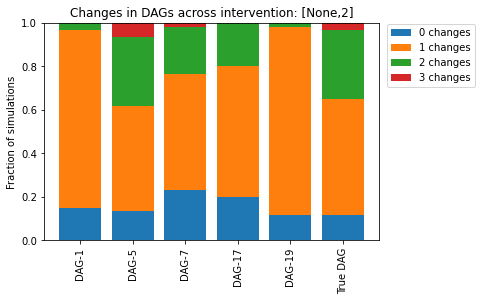

Targets:  [None,(0,1)]


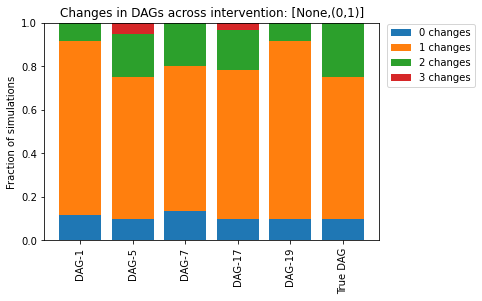

Targets:  [None,(1,2)]


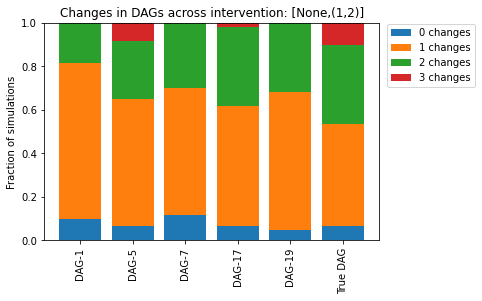

Targets:  [None,(0,2)]


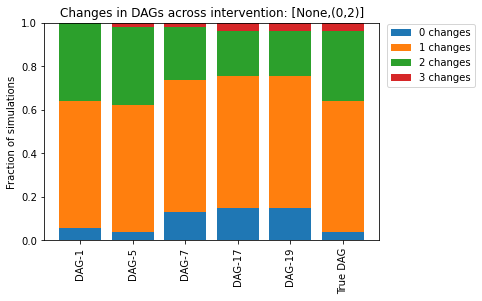

In [11]:
df = pd.read_csv('./bivariate_cdnod_pvalues.csv', header=[0, 1], delimiter=', ', engine='python')

alpha = 0.05 / 3

for params_index in df['Params']['params_index'].unique():
    sub_df = df[df['Params']['params_index'] == params_index]
    targets = sub_df['Params', 'intervention_targets'].iloc[0]
    print('Targets: ', targets)

    changes = np.asarray([
        np.sum(sub_df[key].to_numpy() < alpha, axis=1)
        for key in dag_dict.keys()
    ])

    counts = [
        np.mean(changes == val, axis=1)
        for val in [0, 1, 2, 3]
    ]
    labels = list(dag_dict.keys())
    labels[np.where(np.asarray(labels) == 'DAG-23')[0][0]] = 'True DAG'

    fig, ax = plt.subplots()

    bottom = np.zeros(counts[0].shape[0])
    for i in range(len(counts)):
        ax.bar(labels, counts[i], bottom=bottom,
           label=f'{i} changes')
        bottom += counts[i]

    ax.set_ylabel('Fraction of simulations')
    plt.xticks(rotation=90, ha="center")
    ax.set_title(f'Changes in DAGs across intervention: {targets}')
    ax.legend(bbox_to_anchor=(1.01, 1.02))

    plt.show()

Targets:  [None,0]


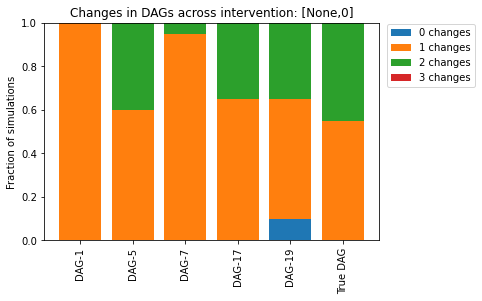

Targets:  [None,1]


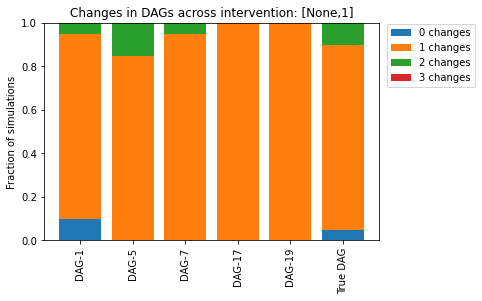

Targets:  [None,2]


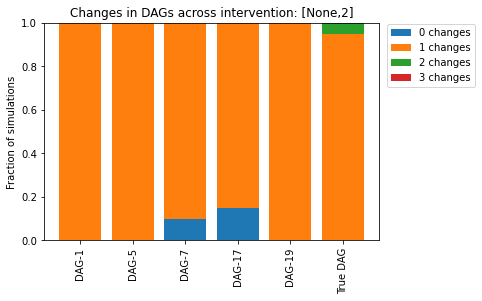

Targets:  [None,(0,1)]


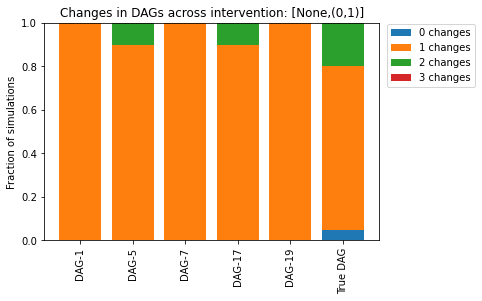

Targets:  [None,(1,2)]


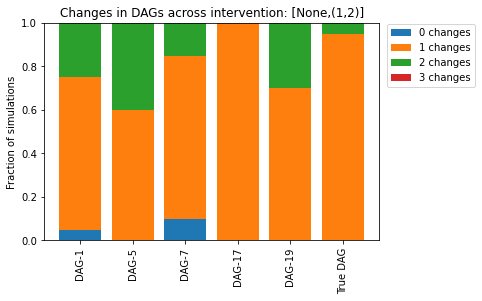

Targets:  [None,(0,2)]


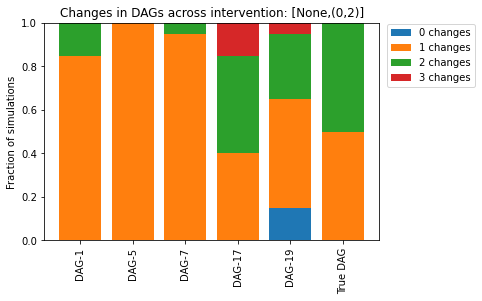

In [80]:
df = pd.read_csv('./icp_triangle_changes.csv', header=[0, 1], delimiter=', ', engine='python')
alpha = 0.05 / 3

for params_index in df['Params']['params_index'].unique():
    sub_df = df[df['Params']['params_index'] == params_index]
    targets = sub_df['Params', 'intervention_targets'].iloc[0]
    print('Targets: ', targets)

    changes = np.asarray([
        np.sum(sub_df[key].to_numpy() < alpha, axis=1)
        for key in dag_dict.keys()
    ])

    counts = [
        np.mean(changes == val, axis=1)
        for val in [0, 1, 2, 3]
    ]
    labels = list(dag_dict.keys())
    labels[np.where(np.asarray(labels) == 'DAG-23')[0][0]] = 'True DAG'

    fig, ax = plt.subplots()

    bottom = np.zeros(counts[0].shape[0])
    for i in range(len(counts)):
        ax.bar(labels, counts[i], bottom=bottom,
           label=f'{i} changes')
        bottom += counts[i]

    ax.set_ylabel('Fraction of simulations')
    plt.xticks(rotation=90, ha="center")
    ax.set_title(f'Changes in DAGs across intervention: {targets}')
    ax.legend(bbox_to_anchor=(1.01, 1.02))

    plt.show()

In [68]:
changes.shape

(6, 20)